In [ ]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, split='train', max_length=2048):
        self.dataset = load_dataset('imdb')[split]
        self.tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        text = item['text']
        label = item['label']

        # tokenizar texto
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'label': torch.tensor(label, dtype=torch.float32),
            'text': text
        }

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self,
                 vocab_size,
                 embedding_dim,
                 hidden_dim,
                 output_dim,
                 dropout):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True) # (B, T, D)
        self.dense1 = nn.Linear(hidden_dim, 128)
        self.act = nn.ReLU()
        self.dense2 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, tokens):
        embeddings = self.embedding(tokens)

        y, (h_t, c_t) = self.rnn(embeddings)
        out = self.dropout(h_t[-1,:,:])
        out = self.dense1(out)
        out = self.act(out)
        out = self.dense2(out)
        out = self.sigmoid(out)

        return out

In [ ]:
class SentimentClassifier_CNN(nn.Module):
    def __init__(self,
                 vocab_size,
                 embedding_dim,
                 interm_dim,
                 output_dim,
                 dropout,
                 pad_idx,
                 filters = [128, 256],
                 kernel = 5):
        super().__init__()

        # embedding layer
        self.embedding = nn.Embedding(vocab_size,
                                      embedding_dim,
                                      padding_idx=pad_idx)

        # first convolutional layer [B, 2048, 64]
        self.conv1 = nn.Conv1d(in_channels=embedding_dim,
                               out_channels=filters[0],
                               kernel_size=kernel,
                               stride=1,
                               padding='same')

        # dim saída: [B, 2048, 64]
        self.conv2 = nn.Conv1d(in_channels=filters[0],
                               out_channels=filters[1],
                               kernel_size=kernel,
                               stride=1,
                               padding='same')
        # pooling
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.act = nn.LeakyReLU(0.1)
        self.dense1 = nn.Linear(in_features=filters[0]*filters[1], out_features=interm_dim)
        self.dense2 = nn.Linear(in_features=interm_dim, out_features=output_dim)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, tokens):
        # [B, 2048, 1]
        embedded = self.embedding(tokens).permute(0,2,1)

        # [B, 2048, 64]
        # first convolutional layer
        out = self.conv1(embedded)
        out = self.pool(out)
        out = self.act(out)

        # [B, 1024, 128]
        # second convolutional layer
        out = self.conv2(out)
        out = self.pool(out)
        out = self.act(out)

        # [B, 512, 256]
        out = self.dense1(out)
        out = self.dropout(out)
        out = self.act(out)

        # [B, 128]
        out = self.dense2(out)
        out = self.sigmoid(out)

        # [B, 1]
        return out

In [ ]:
def train_model(model,
                train_loader,
                valid_loader,
                criterion,
                optimizer,
                n_epochs,
                device):
    history = {
        'train_loss': [],
        'valid_loss': [],
        'train_acc': [],
        'valid_acc': []
    }

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0

        for batch_idx, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            # processo forward
            predictions = model(input_ids).squeeze()

            # calcula custo
            loss = criterion(predictions, labels)

            # processo backward
            loss.backward()

            # atualiza pesos
            optimizer.step()

            # training losses
            train_loss += loss.item()
            predictions = (predictions > 0.5).float()
            train_acc += (predictions == labels).sum().item() / len(labels)

        # validação
        model.eval()
        valid_loss = 0.0
        valid_acc = 0.0

        with torch.no_grad():
            for batch_idx, batch in enumerate(valid_loader):
                input_ids = batch['input_ids'].to(device)
                labels = batch['label'].to(device)

                # processo forward
                predictions = model(input_ids).squeeze()

                # calcula custo
                loss = criterion(predictions, labels)

                # training losses
                valid_loss += loss.item()
                predictions = (predictions > 0.5).float()
                valid_acc += (predictions == labels).sum().item() / len(labels)

        train_loss /= len(train_loader)
        valid_loss /= len(valid_loader)
        train_acc /= len(train_loader)
        valid_acc /= len(valid_loader)

        print(f'Epoch: {epoch+1}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, valid loss: {valid_loss:.4f}, valid acc: {valid_acc:.4f}')

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)

    return history


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
train_dataset = IMDBDataset(split='train', max_length=2048)
valid_dataset = IMDBDataset(split='test', max_length=2048)

In [ ]:
# entradas
indices = list(range(len(test_dataset)))

# divisão
valid_indices, test_indices = train_test_split(indices, test_size=0.5, stratify=[])

# coleta subsets
valid_dataset = torch.utils.data.Subset(test_dataset, valid_indices)
test_dataset = torch.utils.data.Subset(test_dataset, test_indices)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
num_tokens = tokenizer.vocab_size
num_tokens

30522

In [ ]:
# inicializar o modelo
model = SentimentClassifier(
    vocab_size=num_tokens,
    embedding_dim=64,
    hidden_dim=32,
    output_dim=1,
    dropout=0.5
).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
# inicializar o modelo
model = SentimentClassifier_CNN(
    vocab_size=num_tokens,
    embedding_dim=64,
    interm_dim=32,
    output_dim=1,
    dropout=0.5,
    filters = [128, 256],
    kernel = 5,
    pad_idx=tokenizer.pad_token_id
).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
model

SentimentClassifier(
  (embedding): Embedding(30522, 64)
  (rnn): LSTM(64, 32, batch_first=True)
  (dense1): Linear(in_features=32, out_features=128, bias=True)
  (act): ReLU()
  (dense2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (sigmoid): Sigmoid()
)

In [ ]:
# treinamento do modelo
history = train_model(
    model,
    train_loader,
    valid_loader,
    criterion,
    optimizer,
    n_epochs=5,
    device=device
)

Epoch: 1, train loss: 0.6940, train acc: 0.4996, valid loss: 0.6929, valid acc: 0.5083
Epoch: 2, train loss: 0.6900, train acc: 0.5231, valid loss: 0.6843, valid acc: 0.5368
Epoch: 3, train loss: 0.6715, train acc: 0.5626, valid loss: 0.6809, valid acc: 0.5420
Epoch: 4, train loss: 0.6457, train acc: 0.5954, valid loss: 0.6963, valid acc: 0.5388
Epoch: 5, train loss: 0.6277, train acc: 0.6133, valid loss: 0.6909, valid acc: 0.5642


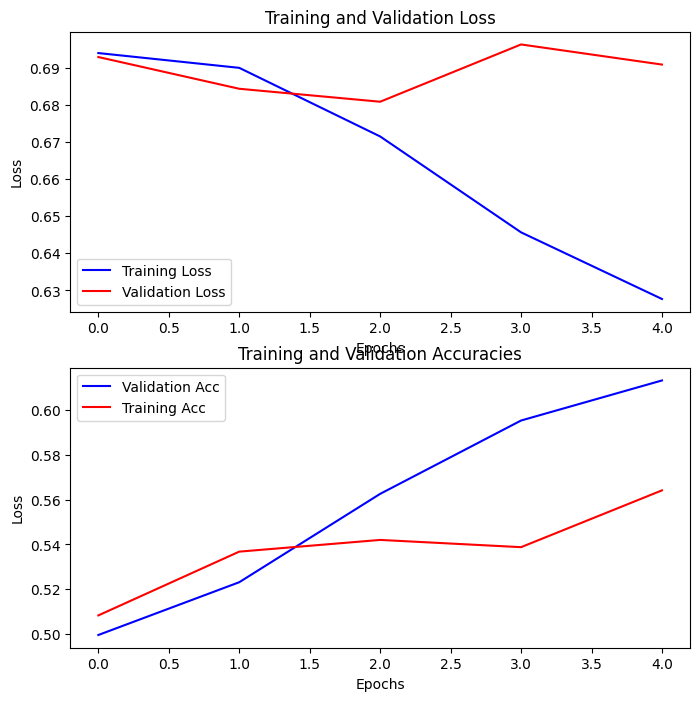

In [ ]:
def make_plots(history):
    # losses
    loss_values = history['train_loss']
    val_loss_values = history['valid_loss']

    # accuracy
    accuracies = history['train_acc']
    val_accuracies = history['valid_acc']

    epochs = range(len(accuracies))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))

    ax1.plot(epochs, loss_values, 'b', label='Training Loss')
    ax1.plot(epochs, val_loss_values, 'r', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(epochs, accuracies, 'b', label='Validation Acc')
    ax2.plot(epochs, val_accuracies, 'r', label='Training Acc')
    ax2.set_title('Training and Validation Accuracies')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()